# Rozpoznávání číslic pomocí neuronových sítí

!pip install -r requirements.txt

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

In [28]:
# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
device = 'cpu'  # Force CPU for this example

In [29]:
torch.device(device)

device(type='cuda')

## Příprava dat

In [30]:
from torchvision.datasets import MNIST

dataset = MNIST(root = 'data/', download = True)
print(len(dataset))

60000


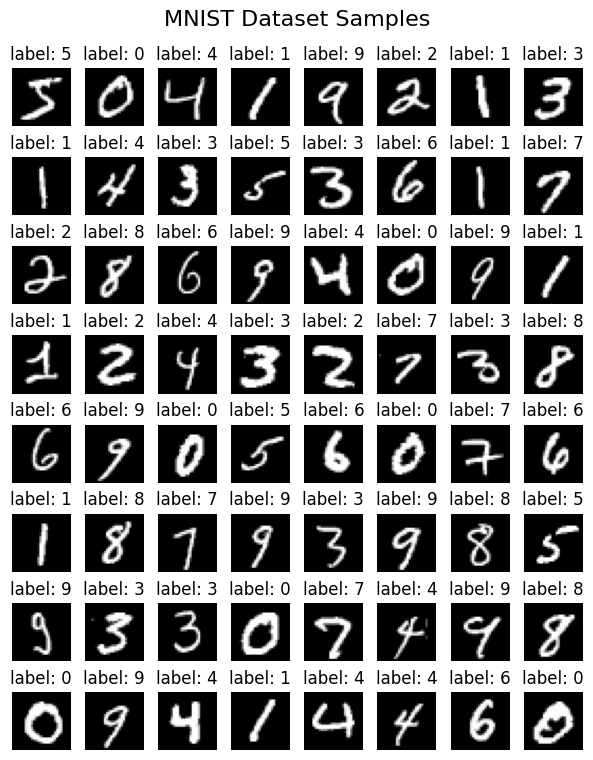

In [31]:
N = 64
plt.figure(figsize=(6, 8))
for i in range(N):
    a = int(np.sqrt(N))
    plt.subplot(a, a, i + 1)
    image, label = dataset[i]
    #image = np.array(image)
    #image = image.reshape((28, 28))
    plt.axis('off')
    plt.imshow(image, cmap = 'gray')
    plt.title(f'label: {label}')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle('MNIST Dataset Samples', fontsize=16)
plt.show()

In [32]:
test_fraction = 0.2

Ntrain = int(len(dataset) * (1 - test_fraction))
print(f'Train size: {Ntrain}, Test size: {len(dataset) - Ntrain}')

X_train, y_train = dataset.data[:Ntrain], dataset.targets[:Ntrain]
X_test, y_test = dataset.data[Ntrain:], dataset.targets[Ntrain:]

Train size: 48000, Test size: 12000


In [33]:
# Scale images to the [0, 1] range
X_train = X_train.float() / 255
X_test = X_test.float() / 255

X_train = X_train.unsqueeze(1)  # Add channel dimension
X_test = X_test.unsqueeze(1)    # Add channel dimension

def to_categorical(y, num_classes):
    """ 1-hot encodes a tensor """
    return torch.eye(num_classes)[y].float()

num_classes = 10

# convert class vectors to binary class matrices
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [34]:
X_train.shape

torch.Size([48000, 1, 28, 28])

In [35]:
y_train[0], y_train.shape

(tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]), torch.Size([48000, 10]))

## Konstrukce modelu

In [79]:
import torch.nn as nn
import torch.optim as optim

channels_1 = 64
channels_2 = 128

model = nn.Sequential(
    nn.Conv2d(kernel_size=3, in_channels=1, out_channels=channels_1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),
    nn.Dropout(0.2),
    nn.Conv2d(kernel_size=3, in_channels=channels_1, out_channels=channels_2, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),
    nn.Flatten(),  # Flatten the output for the fully connected layer
    nn.Dropout(0.2),
    nn.Linear(7*7*channels_2, 10),
    #nn.ReLU(),
    #nn.Linear(40, 10),
    #nn.Softmax(dim=0)  # Softmax for multi-class classification
).to(device)
print(model)

# loss function and optimizer
loss_fn = nn.CrossEntropyLoss().to(device)  # cross entropy
optimizer = optim.Adam(model.parameters(), lr=0.001)

Sequential(
  (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (3): Dropout(p=0.2, inplace=False)
  (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): ReLU()
  (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (7): Flatten(start_dim=1, end_dim=-1)
  (8): Dropout(p=0.2, inplace=False)
  (9): Linear(in_features=6272, out_features=10, bias=True)
)


In [80]:
from torchsummary import summary

summary(model, input_size=(1, 28, 28), device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 28, 28]             640
              ReLU-2           [-1, 64, 28, 28]               0
         MaxPool2d-3           [-1, 64, 14, 14]               0
           Dropout-4           [-1, 64, 14, 14]               0
            Conv2d-5          [-1, 128, 14, 14]          73,856
              ReLU-6          [-1, 128, 14, 14]               0
         MaxPool2d-7            [-1, 128, 7, 7]               0
           Flatten-8                 [-1, 6272]               0
           Dropout-9                 [-1, 6272]               0
           Linear-10                   [-1, 10]          62,730
Total params: 137,226
Trainable params: 137,226
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 1.48
Params size (MB): 0.52
Estimated T

## Trénování neuronové sítě

In [81]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    y_true = torch.argmax(y_true, dim=1)  # Convert one-hot encoded labels to class indices
    y_pred = torch.argmax(y_pred, dim=1)  # Convert model outputs to class indices
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

In [82]:
n_epochs = 5    # number of epochs to run
batch_size = 128  # size of each batch
batches_per_epoch = len(X_train) // batch_size

loss_array = []  # to store loss values
acc_array = []  # to store accuracy values
test_acc_array = []  # to store test accuracy values

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(n_epochs):
    ### Training
    model.train()
    
    for i in range(batches_per_epoch):    
        start = i * batch_size
        # take a batch
        Xbatch = X_train[start:start+batch_size]
        ybatch = y_train[start:start+batch_size]
        # forward pass
        y_pred = model(Xbatch)
        #print(y_pred.shape, y_pred[0,:])
        loss = loss_fn(y_pred, ybatch)
        acc = accuracy_fn(ybatch, y_pred) 
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        # update weights
        optimizer.step()
        
        loss_array.append(loss.item())
        acc_array.append(acc)
        
        print(f'Epoch {epoch + 1}/{n_epochs}, Batch {i + 1}/{batches_per_epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}%', end='\r')    
        
    ### Testing
    model.eval()
    with torch.inference_mode():
        # 1. Forward pass
        y_pred = model(X_test).squeeze() 
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(y_pred, y_test)
        test_acc = accuracy_fn(y_test, y_pred)
        
        test_acc_array.append(test_acc)

        # Print out what's happening every epoch
        print(f"Epoch: {epoch + 1} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")
        

Epoch: 1 | Loss: 0.11521, Accuracy: 96.09% | Test loss: 0.07310, Test acc: 97.89%
Epoch: 2 | Loss: 0.08431, Accuracy: 95.31% | Test loss: 0.05536, Test acc: 98.28%
Epoch: 3 | Loss: 0.03126, Accuracy: 99.22% | Test loss: 0.05121, Test acc: 98.45%
Epoch: 4 | Loss: 0.03578, Accuracy: 99.22% | Test loss: 0.04268, Test acc: 98.82%
Epoch: 5 | Loss: 0.03165, Accuracy: 98.44% | Test loss: 0.04253, Test acc: 98.90%


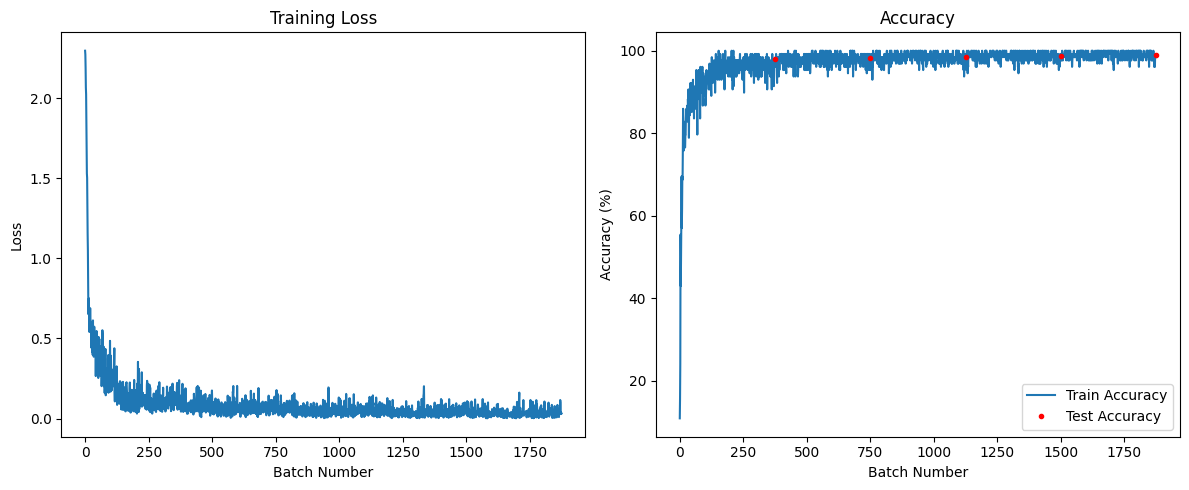

In [83]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(loss_array)
plt.title('Training Loss')
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.subplot(1, 2, 2)
plt.plot(acc_array, label='Train Accuracy')
plt.plot((np.arange(n_epochs)+1)*batches_per_epoch, test_acc_array, '.r', label='Test Accuracy')
plt.legend()
plt.title('Accuracy')
plt.xlabel('Batch Number')
plt.ylabel('Accuracy (%)')
plt.tight_layout()

## Ohodnocení modelu

In [84]:
# Make predictions
model.eval()
with torch.inference_mode():
    y_preds = model(X_test)  # Apply softmax to get probabilities

In [85]:
y_pred_nums = np.argmax(y_preds.cpu(), axis=1)
correct = np.sum((y_pred_nums == np.argmax(y_test.cpu(), axis=1)).numpy())  # compare with true labels
print(f'Accuracy: {correct / len(y_test) * 100:.2f}%')

Accuracy: 98.90%


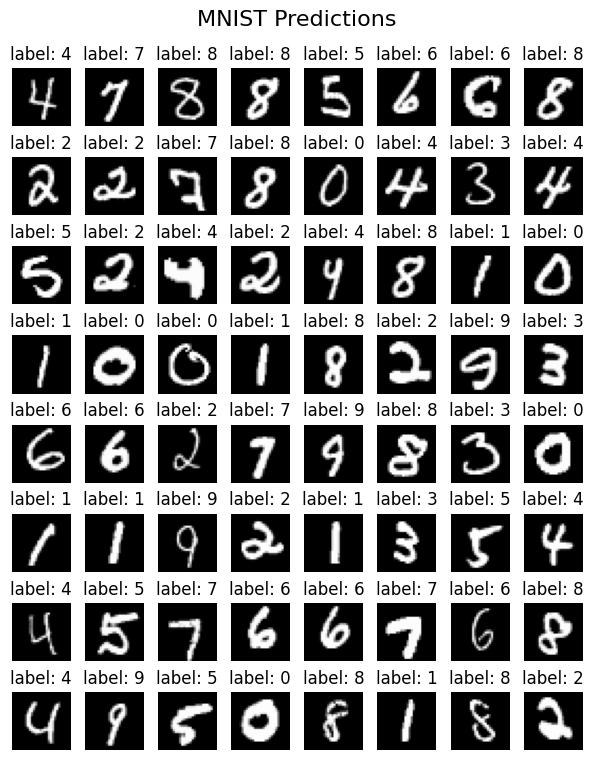

In [86]:
N = 64
plt.figure(figsize=(6, 8))
for i in range(N):
    a = int(np.sqrt(N))
    plt.subplot(a, a, i + 1)
    image = X_test[i].cpu().squeeze().numpy()  # Remove channel dimension
    label = np.argmax(y_preds[i].cpu().detach().numpy())
    plt.axis('off')
    plt.imshow(image, cmap = 'gray')
    plt.title(f'label: {label}')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle('MNIST Predictions', fontsize=16)
plt.show()